## Analiza homomorficzna głosu męskiego

Sygnał mowy jest splotem pobudzenia (ton krtaniowego) i odpowiedzi impulsowej toru głosowego. Ton krtaniowy jest ciągiem impulsów o pewnej częstotliwości. W celu uzyskania oddzielonych informacji o torze głosowym, czyli o właściwościach rezonansowych naszego tonu głosowego i pobudzeniu należy dokonać filtracji homomorficznej względem splotu.

dodac do opisu schemat blokowy idei przetwarzania sygnału, 

In [2]:
#Biblioteki wykorzystane do wykonania analizy
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile

Wszystkie niezbędne operacje potrzebne do wykoanania analizy zaimplementowane zostały w formie klas, co zostało przedstawione poniżej. 

In [3]:
class Sound:
    def __init__(self, filename):
        [self.sample_rate, self.samples] = wavfile.read(f"recordings/{filename}.wav")
        self.filename = filename
        self.logSpectrum = []
        self.cepstrum = []
        self.cepstrumHP = []
        self.cepstrumLP = []
        self.logSpectrumLP = []
        self.logSpectrumHP = []
        self.signalLP = []
        self.signalHP = []

    def calcDuration(self):
        return len(self.samples)/self.sample_rate

    def getTimeAxis(self):
        return np.linspace(0, len(self.samples)/self.sample_rate, len(self.samples))

    def plot(self, signal = [], title='', xlabel='', ylabel='', xAxis = []):
        if not len(signal):
            signal = self.samples
        if not len(xAxis):
            xAxis = range(len(signal))

        plt.figure(figsize=(15, 5))
        plt.plot(xAxis, signal)
        plt.title(f'{title} {self.filename}')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    def drawSpectrogram(self, title="Spektogram sygnału "):
        plt.figure(figsize=(15, 5))
        plt.specgram(self.samples, Fs=self.sample_rate, NFFT=1024, window=np.hanning(1024))
        plt.title(f'{title} {self.filename}')
        plt.ylabel('Czestotliwosc (Hz)')
        plt.xlabel('Czas [s]')
        plt.xlim(0, self.calcDuration())
        plt.colorbar()
        plt.show()

    def cutSignal(self, start, end):
        self.samples = self.samples[int(start * self.sample_rate) : int(end * self.sample_rate)]
    
    def decimate(self, times):
        self.samples = signal.decimate(self.samples, times)
        self.sample_rate = self.sample_rate / times

    def calcLogSpectrum(self):
        samples_fft = np.fft.fft(self.samples)
        # samples_fftabs2 = np.abs(samples_fft)
        self.logSpectrum = np.log(samples_fft)

    def calcCepstrum(self):
        logspectrum_fft = np.fft.fft(self.logSpectrum)
        # logspectrum_fftabs = np.abs(logspectrum_fft)
        self.cepstrum = np.log(logspectrum_fft)

    def filter(self, marginAsRatio):
        leng = len(self.cepstrum)
        margin = round(marginAsRatio * leng)

        filtrHP = [0] * margin + [1] * (leng - 2 * margin) + [0] * margin
        filtrLP = np.logical_not(filtrHP)

        self.cepstrumHP = np.multiply(self.cepstrum, filtrHP)
        self.cepstrumLP = np.multiply(self.cepstrum, filtrLP)

    def reverseToLogSpectrum(self, cepstrum):
        return np.fft.ifft(np.exp(cepstrum))

    def reverseToSignal(self, logSpectrum):
        return np.fft.ifft(np.exp(logSpectrum))
    
    def calcReversedLogSpectrums(self):
        self.logSpectrumHP = self.reverseToLogSpectrum(self.cepstrumHP)
        self.logSpectrumLP = self.reverseToLogSpectrum(self.cepstrumLP)

    def calcReversedSignals(self):
        self.signalHP = self.reverseToSignal(self.logSpectrumHP)
        self.signalLP = self.reverseToSignal(self.logSpectrumLP)

    def calculateAll(self, sigBegin=1.3, sigEnd=1.6, cepstrumMargin=0.05):
        self.cutSignal(sigBegin, sigEnd)
        self.decimate(4)
        self.calcLogSpectrum()
        self.calcCepstrum()
        self.filter(cepstrumMargin)
        self.calcReversedLogSpectrums()
        self.calcReversedSignals()

# Analiza samogłoski "A"

Poniżej zaprezentowany został przebieg sygnału samogłoski "A", będący splotem toru krtaniowego i  toru głosowego

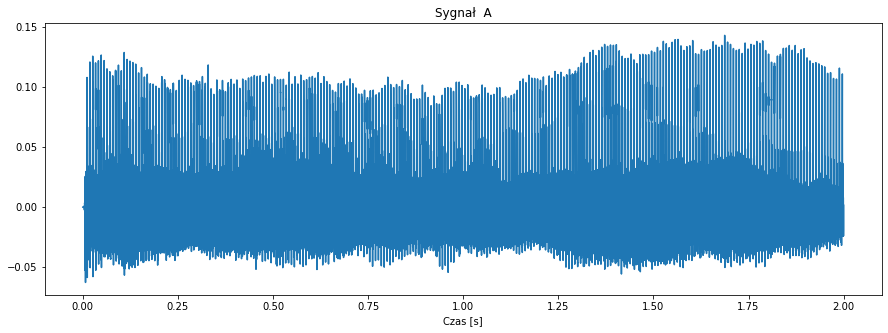

In [4]:
    sound = Sound('A')
    sound.plot(sound.samples, "Sygnał ", "Czas [s]", "", sound.getTimeAxis())

Z otrzymanego przebiegu samogłoski wycięty został kawałek, w którym sygnał jest niezmienny w czasie. W celu potwierdzenia jego niezmienności narysowane zostało spektrum wyciętego sygnału, co zostało zaprezentowane poniżej. 

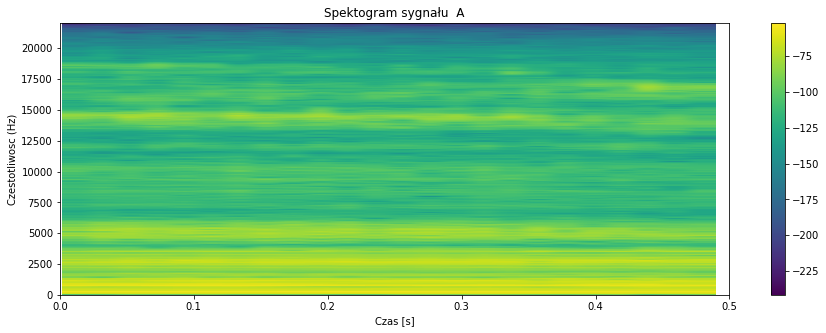

In [5]:
    sound.cutSignal(1.25, 1.75)
    sound.drawSpectrogram()

Natępnie wykonana została próba dobrania odpowiedniego stopnia decymacji badanego sygnału. Operacja decymacji polega na X-krotnym zmniejszeniu częstotliwości próbkowania sygnału. 

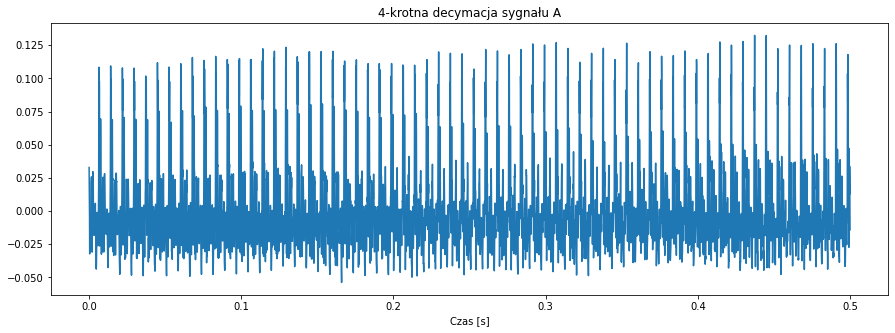

In [6]:
    sound.decimate(4)
    sound.plot(sound.samples, "4-krotna decymacja sygnału", "Czas [s]", "", sound.getTimeAxis())

Na podstawie przeprowadzonej analizy dla kilku wartości decymacji, stwierdzono, że najbardziej korzystną wartością dla kolejnych operacji jest 4-krotne zmniejszenie częstotliwości próbkowania. 

Poniżej przedstawione zostało widmo mocy badanego sygnału. 

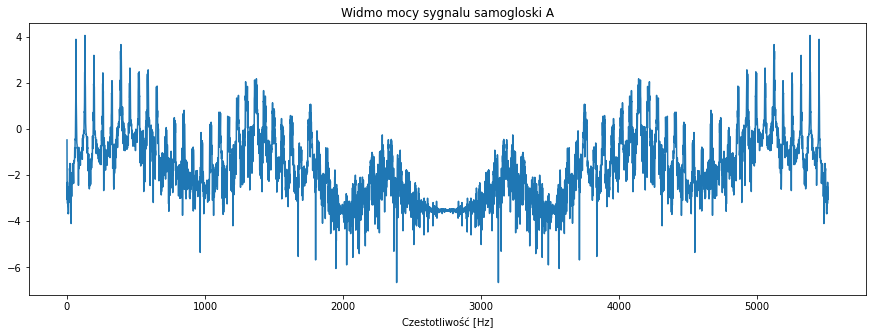

In [7]:
    sound.calcLogSpectrum()
    sound.plot(sound.logSpectrum.real, "Widmo mocy sygnalu samogloski", "Czestotliwość [Hz]")

Następnie wygenerowany został przebieg cepstrum rzeczywistego, będącego kwadratem modułu TF logarytmu widma mocy sygnału. 

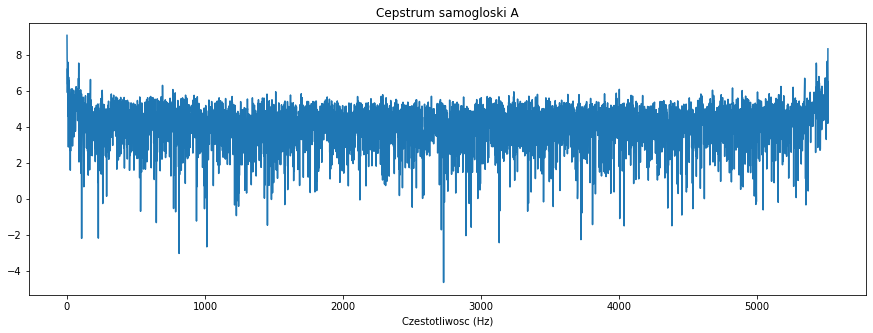

In [8]:
    sound.calcCepstrum()
    sound.plot(sound.cepstrum.real, "Cepstrum samogloski", 'Czestotliwosc (Hz)')

Patrząc na uzyskane cepstrum sygnału, widmo związane z właściwościami toru głosowego jest usytuowane w początkowej fazie tego wykresu, natomiast szpilki występujące w dalszym przebiegu są związane z torem krtaniowym. 

Po przeprowadzeniu informacji z postaci splotowej do postaci addytywnej, wykonana mogła zostać filtracja liniowa w dwóch torach - dolnoprzepustowym (głosowym) i górnoprzepustowym (krtaniowym). Wyniki tej filtracji przedstawione zostały poniżej. 

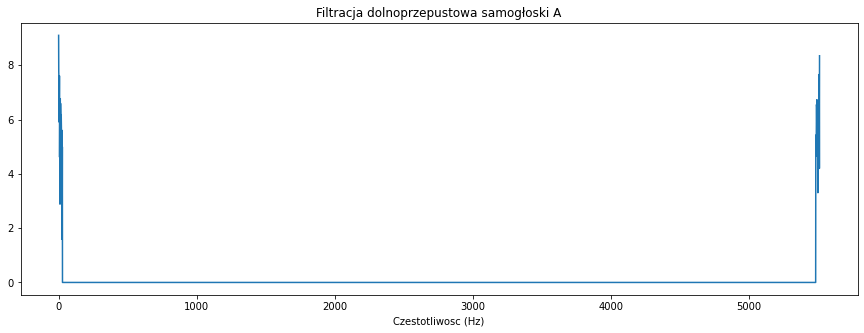

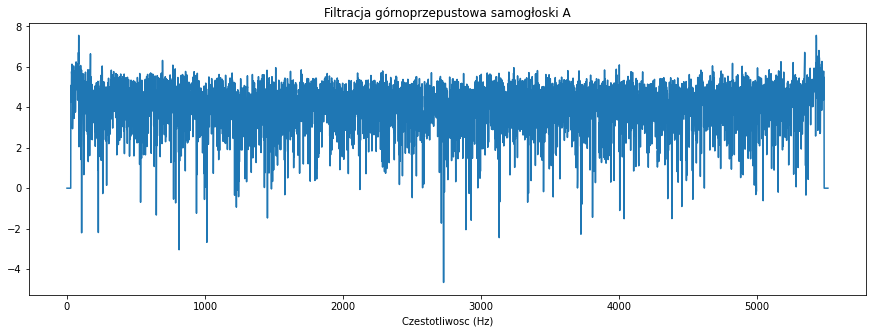

In [9]:
    sound.filter(0.005)
    sound.plot(sound.cepstrumLP.real, "Filtracja dolnoprzepustowa samogłoski", 'Czestotliwosc (Hz)')
    sound.plot(sound.cepstrumHP.real, "Filtracja górnoprzepustowa samogłoski", 'Czestotliwosc (Hz)')

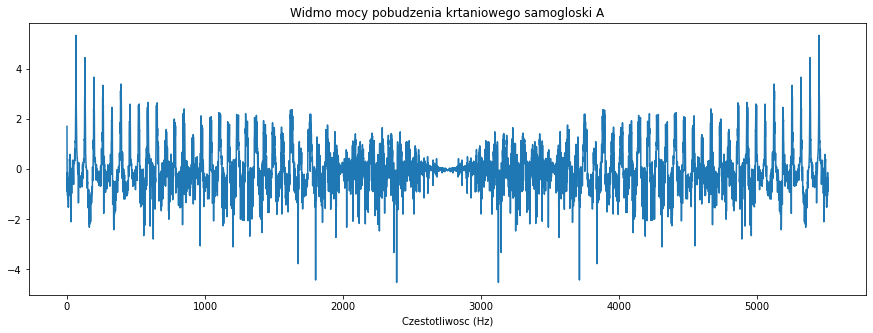

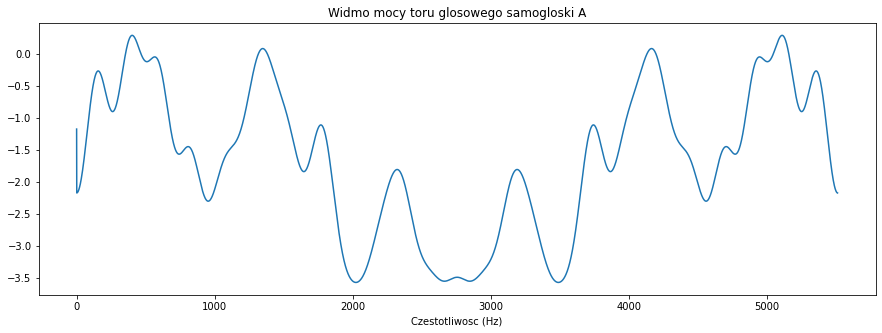

In [10]:
    sound.calcReversedLogSpectrums()
    sound.plot(sound.logSpectrumHP.real, "Widmo mocy pobudzenia krtaniowego samogloski", 'Czestotliwosc (Hz)')
    sound.plot(sound.logSpectrumLP.real, "Widmo mocy toru glosowego samogloski", 'Czestotliwosc (Hz)')

#tu koniec

Przedstawione poniżej widmo pobudzenia krtaniowego zawiera wiele ewolucji, ponieważ jest to ciąg impulsów powtarzanych z częstotliwością zależną od płci wypowiadającej się osoby. 

Sygnał toru głosowego po przeprowadzonej filtracji ma symetryczną charakterystykę względem początku układu, ponieważ przy zastosowaniu cepstrum rzeczywistego, informacja o fazie nie została przeniesiona przez algorytm, w związku z czym ta faza z punktu widzenia algorytmu jest ona zerowa. 

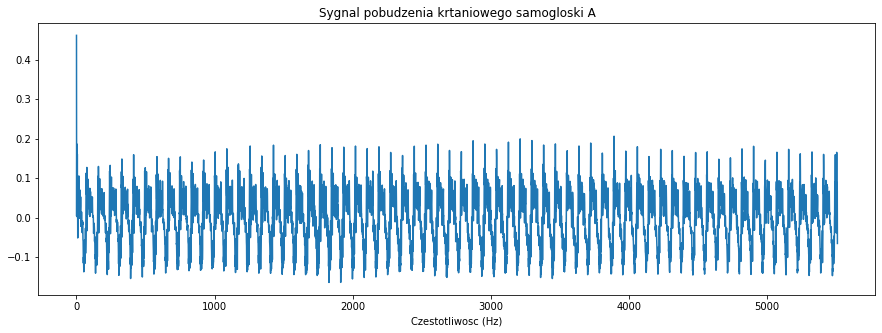

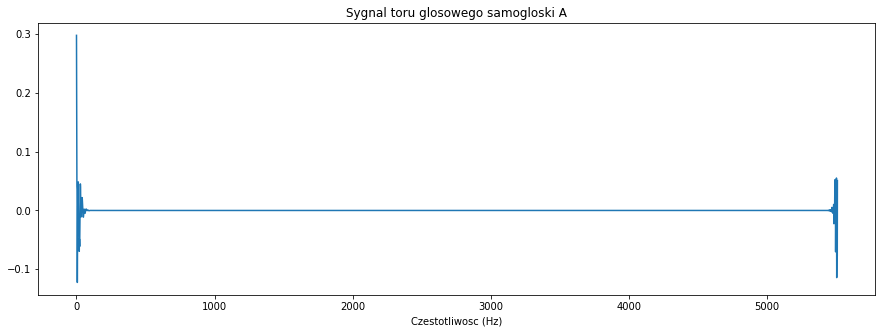

In [11]:
    sound.calcReversedSignals()
    sound.plot(sound.signalHP.real, "Sygnal pobudzenia krtaniowego samogloski", 'Czestotliwosc (Hz)')
    sound.plot(sound.signalLP.real, "Sygnal toru glosowego samogloski", 'Czestotliwosc (Hz)')

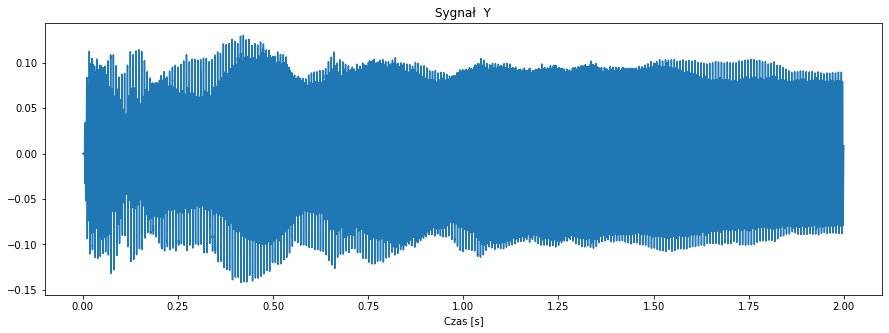

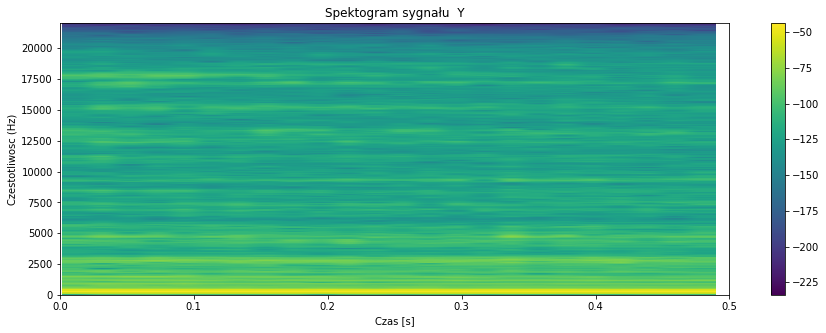

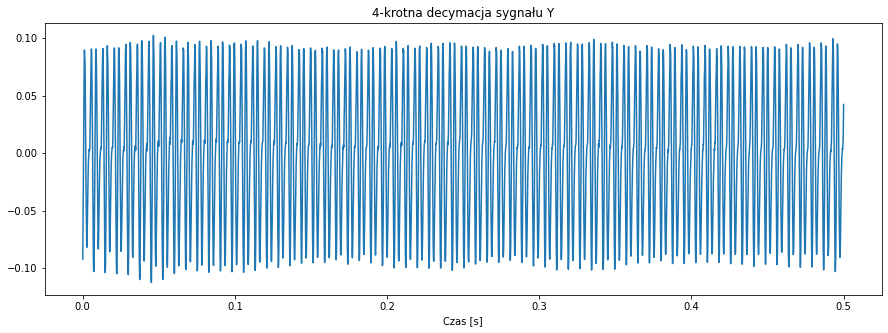

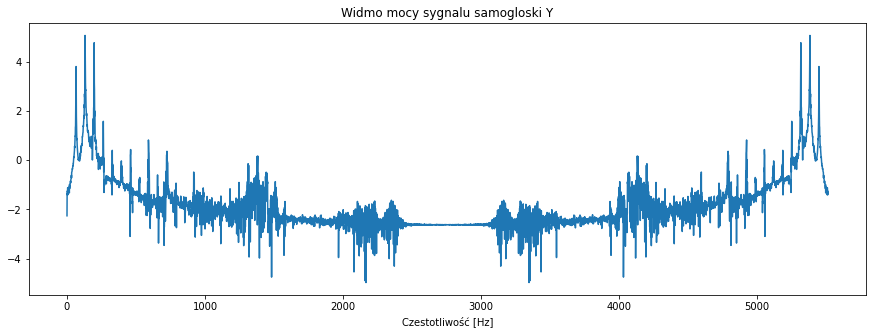

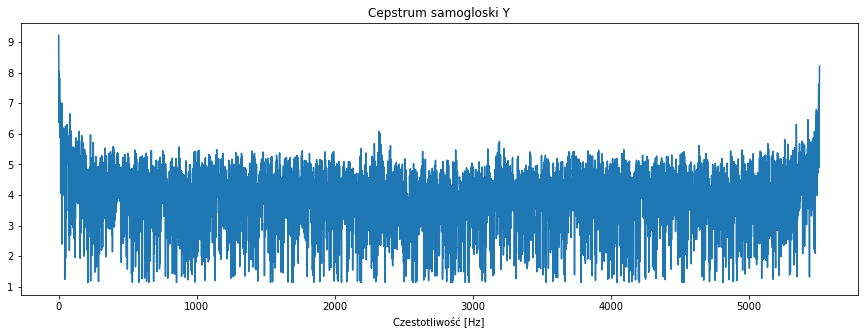

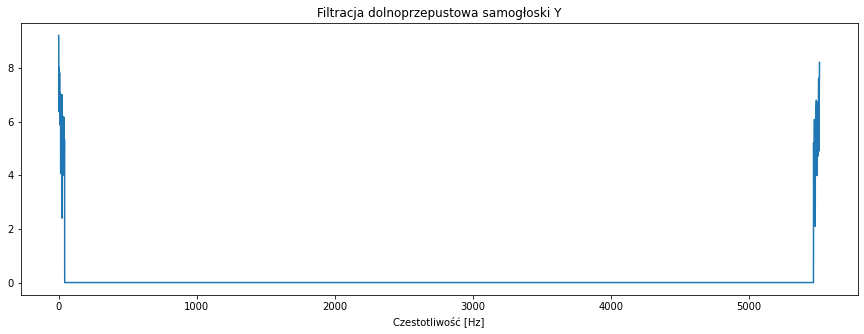

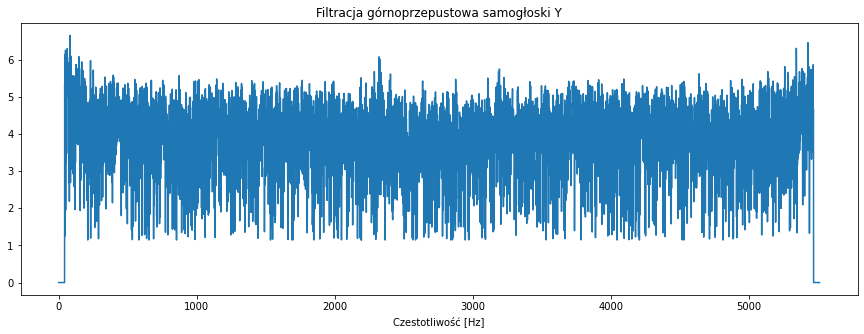

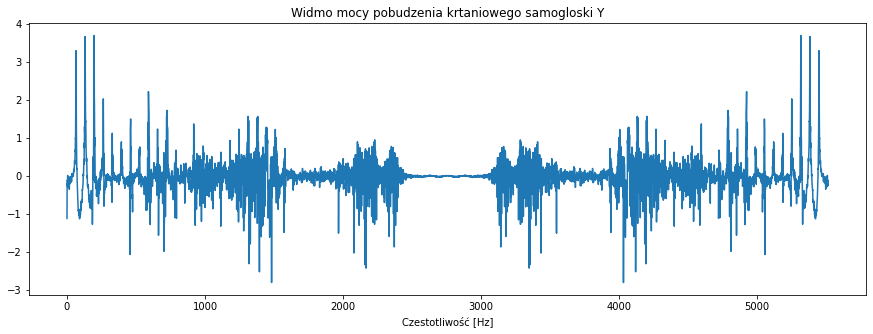

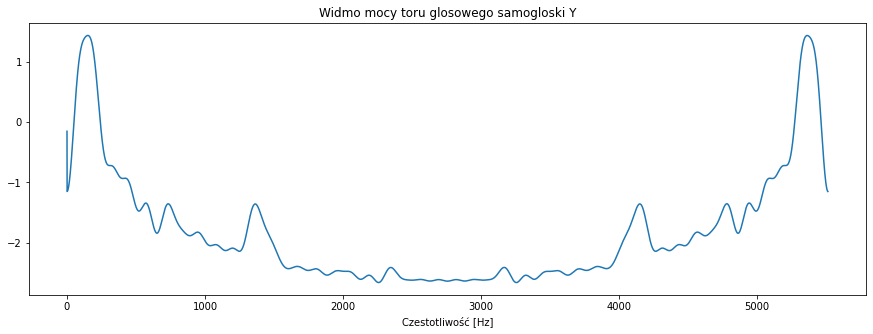

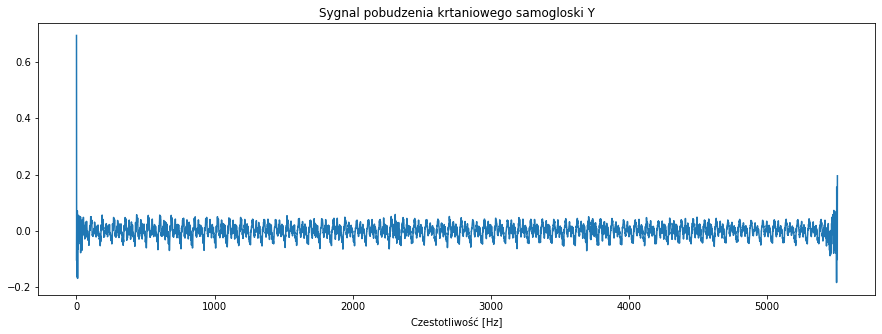

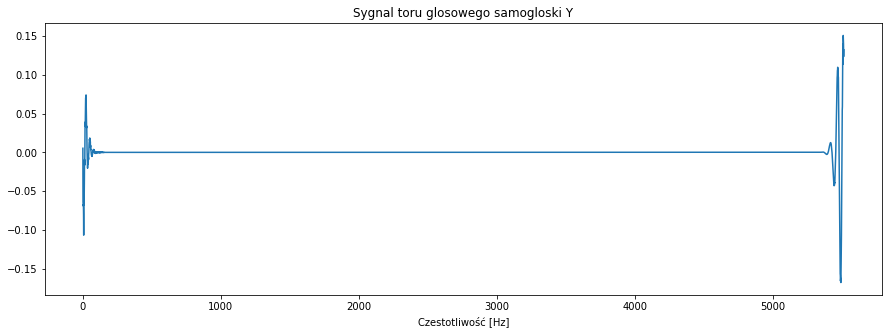

In [15]:
    sound = Sound('Y')
    sound.plot(sound.samples, "Sygnał ", "Czas [s]", "", sound.getTimeAxis())
    sound.cutSignal(1.00, 1.50)
    sound.drawSpectrogram()
    sound.decimate(4)
    sound.plot(sound.samples, "4-krotna decymacja sygnału", "Czas [s]", "", sound.getTimeAxis())
    sound.calcLogSpectrum()
    sound.plot(sound.logSpectrum.real, "Widmo mocy sygnalu samogloski", "Czestotliwość [Hz]")
    sound.calcCepstrum()
    sound.plot(sound.cepstrum.real, "Cepstrum samogloski", "Czestotliwość [Hz]")

    sound.filter(0.008)
    sound.plot(sound.cepstrumLP.real, "Filtracja dolnoprzepustowa samogłoski", "Czestotliwość [Hz]")
    sound.plot(sound.cepstrumHP.real, "Filtracja górnoprzepustowa samogłoski", "Czestotliwość [Hz]")

    sound.calcReversedLogSpectrums()
    sound.plot(sound.logSpectrumHP.real, "Widmo mocy pobudzenia krtaniowego samogloski", "Czestotliwość [Hz]")
    sound.plot(sound.logSpectrumLP.real, "Widmo mocy toru glosowego samogloski", "Czestotliwość [Hz]")

    sound.calcReversedSignals()
    sound.plot(sound.signalHP.real, "Sygnal pobudzenia krtaniowego samogloski", "Czestotliwość [Hz]")
    sound.plot(sound.signalLP.real, "Sygnal toru glosowego samogloski", "Czestotliwość [Hz]")

interpretacja porównawcza do wyników wartości formantów z literatury 